In [28]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt

In [29]:
df = r"/Users/bertrandnkongdem/Downloads/Data Analytics Portfolio/SQL-Based Analysis of Product Sales/Chinook_Sqlite.sqlite"  # change this
conn = sqlite3.connect(df)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,Album,Album,19,CREATE TABLE [Album]\n(\n [AlbumId] INTEGER...
1,table,Artist,Artist,281,CREATE TABLE [Artist]\n(\n [ArtistId] INTEG...
2,table,Customer,Customer,386,CREATE TABLE [Customer]\n(\n [CustomerId] I...
3,table,Employee,Employee,392,CREATE TABLE [Employee]\n(\n [EmployeeId] I...
4,table,Genre,Genre,395,CREATE TABLE [Genre]\n(\n [GenreId] INTEGER...
5,table,Invoice,Invoice,396,CREATE TABLE [Invoice]\n(\n [InvoiceId] INT...
6,table,InvoiceLine,InvoiceLine,399,CREATE TABLE [InvoiceLine]\n(\n [InvoiceLin...
7,table,MediaType,MediaType,402,CREATE TABLE [MediaType]\n(\n [MediaTypeId]...
8,table,Playlist,Playlist,404,CREATE TABLE [Playlist]\n(\n [PlaylistId] I...
9,table,PlaylistTrack,PlaylistTrack,405,CREATE TABLE [PlaylistTrack]\n(\n [Playlist...


### To see few invoices 

In [36]:
query = """
SELECT *
FROM Invoice
LIMIT 5;
"""
df = pd.read_sql(query, conn)
print(df)

   InvoiceId  CustomerId          InvoiceDate           BillingAddress  \
0          1           2  2009-01-01 00:00:00  Theodor-Heuss-Straße 34   
1          2           4  2009-01-02 00:00:00         Ullevålsveien 14   
2          3           8  2009-01-03 00:00:00          Grétrystraat 63   
3          4          14  2009-01-06 00:00:00           8210 111 ST NW   
4          5          23  2009-01-11 00:00:00          69 Salem Street   

  BillingCity BillingState BillingCountry BillingPostalCode  Total  
0   Stuttgart         None        Germany             70174   1.98  
1        Oslo         None         Norway              0171   3.96  
2    Brussels         None        Belgium              1000   5.94  
3    Edmonton           AB         Canada           T6G 2C7   8.91  
4      Boston           MA            USA              2113  13.86  


## Total sales per country

In [63]:
query = """
SELECT BillingCountry AS Country,
       SUM(Total)     AS TotalSales
FROM Invoice
GROUP BY BillingCountry
ORDER BY TotalSales DESC;
 """
df = pd.read_sql(query, conn)
print(df.head())


   Country  TotalSales
0      USA      523.06
1   Canada      303.96
2   France      195.10
3   Brazil      190.10
4  Germany      156.48


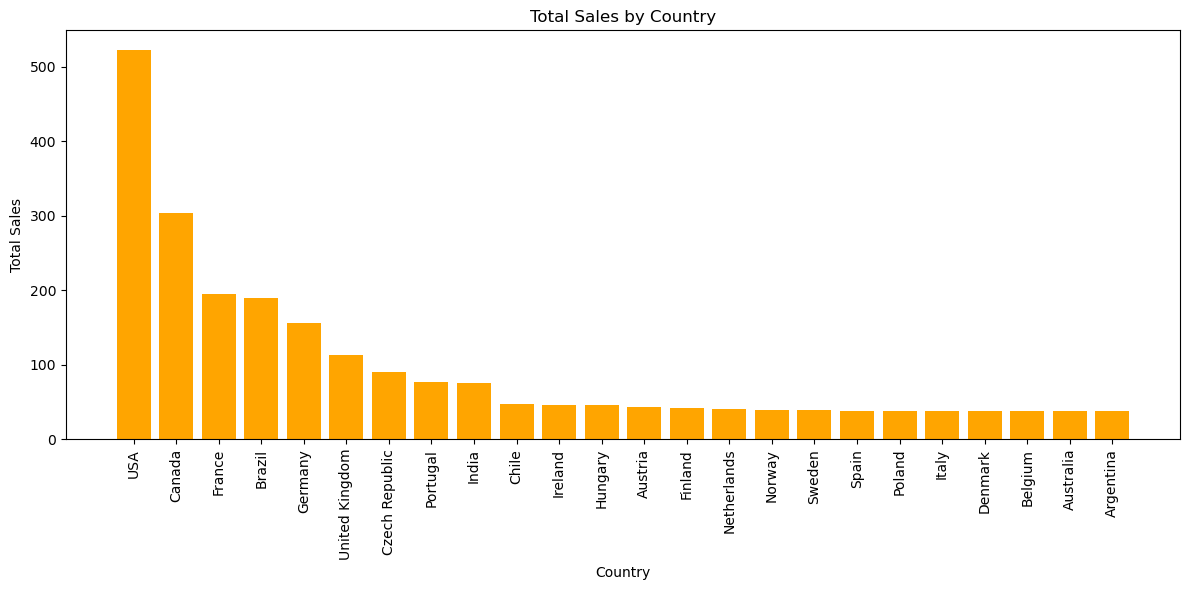

In [53]:
plt.figure(figsize=(12, 6))
plt.bar(df['Country'], df['TotalSales'], color='orange')
plt.title('Total Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Top Ten selling products

In [47]:
query_top_products = """
SELECT t.Name AS TrackName,
       SUM(il.UnitPrice * il.Quantity) AS TotalSales
FROM InvoiceLine il
JOIN Track t ON il.TrackId = t.TrackId
GROUP BY t.TrackId, t.Name
ORDER BY TotalSales DESC
LIMIT 10;
"""
top_products = pd.read_sql(query_top_products, conn)
print(top_products)


                      TrackName  TotalSales
0                The Woman King        3.98
1                       The Fix        3.98
2                     Walkabout        3.98
3                      Hot Girl        3.98
4                Gay Witch Hunt        3.98
5             Phyllis's Wedding        3.98
6  How to Stop an Exploding Man        3.98
7                         Pilot        3.98
8        Occupation / Precipice        1.99
9                 Exodus, Pt. 1        1.99


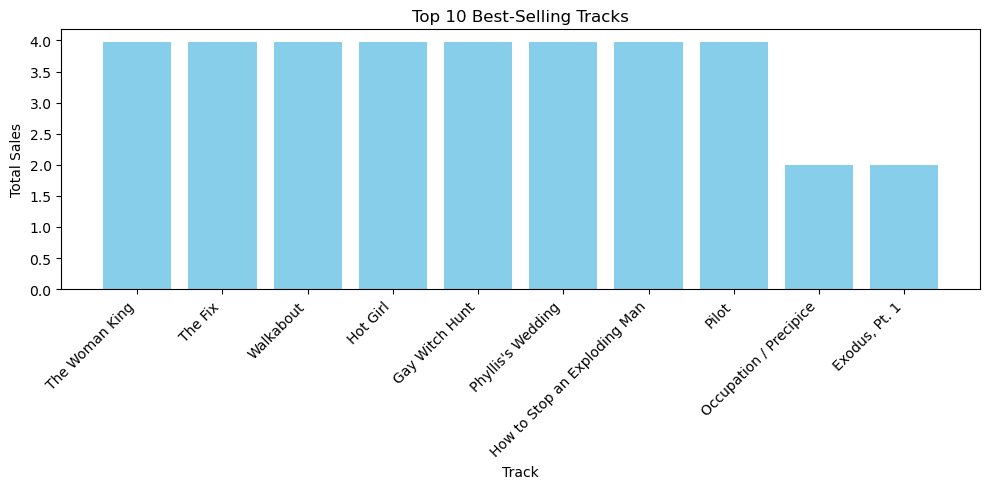

In [48]:
plt.figure(figsize=(10, 5))
plt.bar(top_products['TrackName'], top_products['TotalSales'], color='skyblue')
plt.title('Top 10 Best-Selling Tracks')
plt.xlabel('Track')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Revenue per region (use BillingCountry as region)

In [64]:
query_revenue_region = """
SELECT BillingCountry AS Region,
       SUM(Total)     AS TotalRevenue
FROM Invoice
GROUP BY BillingCountry
ORDER BY TotalRevenue DESC;
"""

revenue_region = pd.read_sql(query_revenue_region, conn)
print(revenue_region.head())

    Region  TotalRevenue
0      USA        523.06
1   Canada        303.96
2   France        195.10
3   Brazil        190.10
4  Germany        156.48


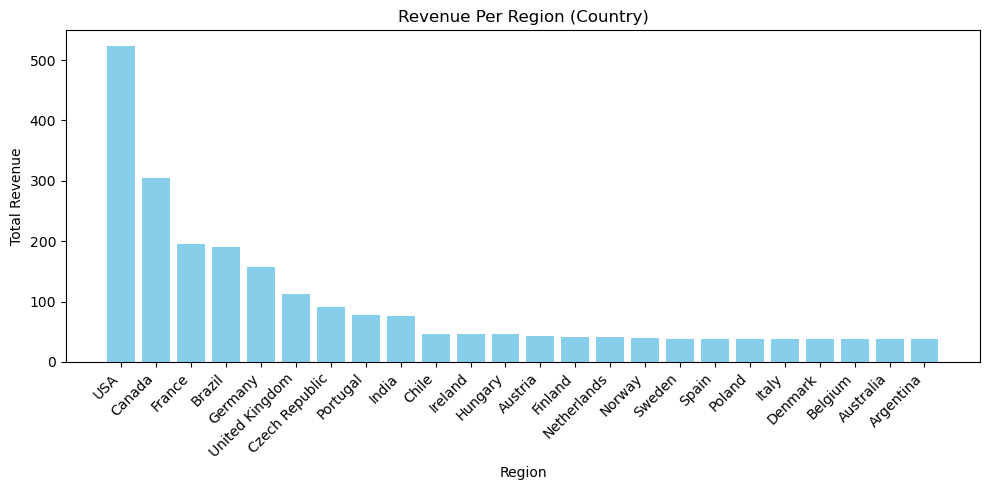

In [73]:
plt.figure(figsize=(10, 5))
plt.bar(revenue_region['Region'], revenue_region['TotalRevenue'], color='skyblue')
plt.title('Revenue Per Region (Country)')
plt.xlabel('Region')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Monthly performance (total revenue per month)

In [65]:
query_monthly = """
SELECT SUBSTR(InvoiceDate, 1, 7) AS YearMonth,   -- 'YYYY-MM'
       SUM(Total)                AS TotalRevenue
FROM Invoice
GROUP BY YearMonth
ORDER BY YearMonth;
"""

monthly_perf = pd.read_sql(query_monthly, conn)
print(monthly_perf.head())

  YearMonth  TotalRevenue
0   2009-01         35.64
1   2009-02         37.62
2   2009-03         37.62
3   2009-04         37.62
4   2009-05         37.62


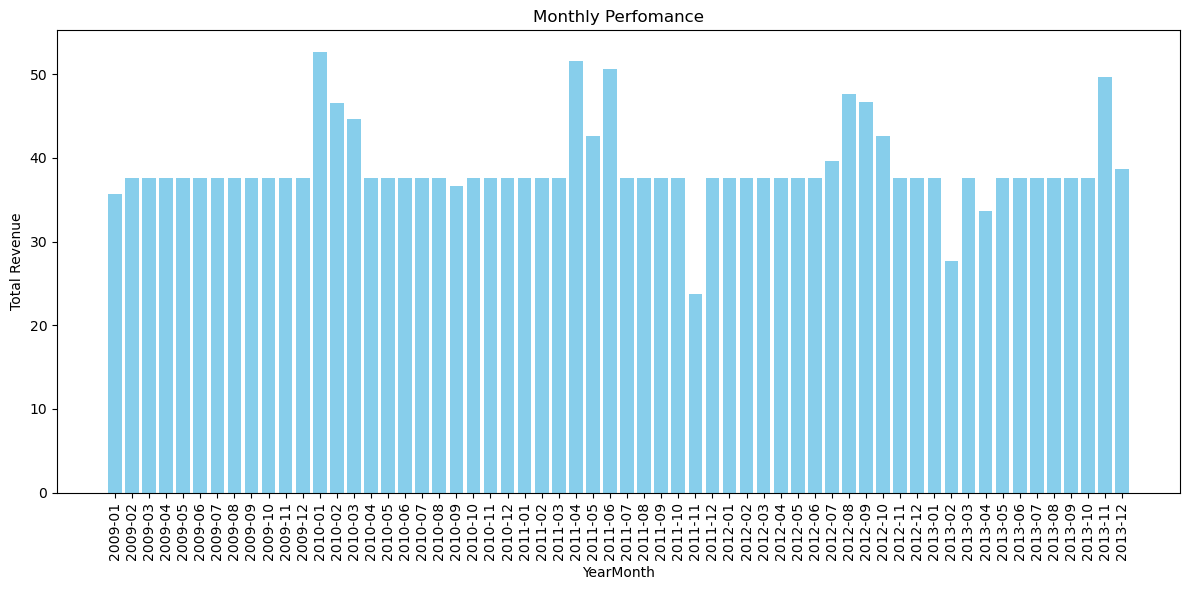

In [98]:
plt.figure(figsize=(12, 6))
plt.bar(monthly_perf['YearMonth'], monthly_perf['TotalRevenue'], color='skyblue')
plt.title('Monthly Perfomance')
plt.xlabel('YearMonth')
plt.ylabel('Total Revenue')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Join products, sales lines, and invoices: Finding out which product, when it was sold, where (billing country), and how much revenue

In [103]:
conn = sqlite3.connect(database)   # open connection again
df = pd.read_sql(query, conn)     
query = """
SELECT
    il.InvoiceLineId,
    i.InvoiceDate,
    i.BillingCountry,
    t.Name       AS TrackName,
    il.UnitPrice,
    il.Quantity,
    il.UnitPrice * il.Quantity AS LineTotal
FROM InvoiceLine il
JOIN Track t
  ON il.TrackId = t.TrackId
JOIN Invoice i
  ON il.InvoiceId = i.InvoiceId;
"""
df.head()

,InvoiceLineId,InvoiceDate,BillingCountry,TrackName,UnitPrice,Quantity,LineTotal
0,1,2009-01-01 00:00:00,Germany,Balls to the Wall,0.99,1,0.99
1,2,2009-01-01 00:00:00,Germany,Restless and Wild,0.99,1,0.99
2,3,2009-01-02 00:00:00,Norway,Put The Finger On You,0.99,1,0.99
3,4,2009-01-02 00:00:00,Norway,Inject The Venom,0.99,1,0.99
4,5,2009-01-02 00:00:00,Norway,Evil Walks,0.99,1,0.99


## Join in album and artist (full product context) 

In [107]:
df = pd.read_sql(query, conn)
query = """
SELECT
    i.InvoiceDate,
    i.BillingCountry,
    ar.Name      AS Artist,
    al.Title     AS Album,
    t.Name       AS TrackName,
    il.UnitPrice,
    il.Quantity,
    il.UnitPrice * il.Quantity AS LineTotal
FROM InvoiceLine il
JOIN Track t
  ON il.TrackId = t.TrackId
JOIN Album al
  ON t.AlbumId = al.AlbumId
JOIN Artist ar
  ON al.ArtistId = ar.ArtistId
JOIN Invoice i
  ON il.InvoiceId = i.InvoiceId;
  """
df.head()

,InvoiceDate,Genre,TrackName,UnitPrice,Quantity,LineTotal
0,2009-01-01 00:00:00,Rock,Balls to the Wall,0.99,1,0.99
1,2009-01-01 00:00:00,Rock,Restless and Wild,0.99,1,0.99
2,2009-01-02 00:00:00,Rock,Put The Finger On You,0.99,1,0.99
3,2009-01-02 00:00:00,Rock,Inject The Venom,0.99,1,0.99
4,2009-01-02 00:00:00,Rock,Evil Walks,0.99,1,0.99


## Rank tracks by sales (overall)

In [108]:
query = """
SELECT
    TrackName,
    TotalSales,
    ROW_NUMBER() OVER (ORDER BY TotalSales DESC) AS RowNum
FROM (
    SELECT
        t.Name AS TrackName,
        SUM(il.UnitPrice * il.Quantity) AS TotalSales
    FROM InvoiceLine il
    JOIN Track t ON il.TrackId = t.TrackId
    GROUP BY t.TrackId, t.Name
) AS sub
ORDER BY TotalSales DESC;
"""

df = pd.read_sql(query, conn)
print(df.head(10))

                      TrackName  TotalSales  RowNum
0                The Woman King        3.98       1
1                       The Fix        3.98       2
2                     Walkabout        3.98       3
3                      Hot Girl        3.98       4
4                Gay Witch Hunt        3.98       5
5             Phyllis's Wedding        3.98       6
6  How to Stop an Exploding Man        3.98       7
7                         Pilot        3.98       8
8        Occupation / Precipice        1.99       9
9                 Exodus, Pt. 1        1.99      10


## Top track per country

In [109]:
query = """
SELECT *
FROM (
    SELECT
        i.BillingCountry AS Country,
        t.Name          AS TrackName,
        SUM(il.UnitPrice * il.Quantity) AS TotalSales,
        RANK() OVER (
            PARTITION BY i.BillingCountry
            ORDER BY SUM(il.UnitPrice * il.Quantity) DESC
        ) AS SalesRank
    FROM InvoiceLine il
    JOIN Invoice i ON il.InvoiceId = i.InvoiceId
    JOIN Track t   ON il.TrackId = t.TrackId
    GROUP BY i.BillingCountry, t.TrackId, t.Name
) AS ranked
WHERE SalesRank = 1
ORDER BY Country;
"""

df = pd.read_sql(query, conn)
print(df.head(20))

      Country                       TrackName  TotalSales  SalesRank
0   Argentina                Chemical Wedding        0.99          1
1   Argentina                        Love Gun        0.99          1
2   Argentina                           Deuce        0.99          1
3   Argentina                       Opus No.1        0.99          1
4   Argentina               How High The Moon        0.99          1
5   Argentina                Take This Bottle        0.99          1
6   Argentina          Surprise! You're Dead!        0.99          1
7   Argentina                  Falamansa Song        0.99          1
8   Argentina                  Medo De Escuro        0.99          1
9   Argentina                   The Last Song        0.99          1
10  Argentina              Friend Of A Friend        0.99          1
11  Argentina                Times Like These        0.99          1
12  Argentina                   Monkey Wrench        0.99          1
13  Argentina                     